In [1]:
# import modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.datasets import fetch_20newsgroups
import nltk
import gensim  
from gensim import models 
from gensim.corpora.dictionary import Dictionary 
from gensim.models import CoherenceModel 
from gensim import corpora 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases
import pyLDAvis 
import pyLDAvis.gensim_models

ModuleNotFoundError: No module named 'pyLDAvis'

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
# read the text data
newsgroups_train = fetch_20newsgroups(subset='train').data
len(newsgroups_train)

11314

In [ ]:
newsgroups_test = fetch_20newsgroups(subset='test').data
len(newsgroups_test)

7532

In [ ]:
# check the text data
newsgroups_train[:2]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

# Tokenize data

In [ ]:
# tokenize data 
word_tokenize = \
[gensim.utils.simple_preprocess(word, min_len=3) for word in newsgroups_train]
# keep only alphabetical characters
clean_tokens = \
[[word for word in doc if word.isalpha()] for doc in word_tokenize]
# remove stop words
no_stops = \
[[t for t in doc if t not in stopwords.words("english")] for doc in clean_tokens]
# instantiate WordNetLemmatizer
lem = WordNetLemmatizer()
# lemmatize tokens 
lemmatized = [[lem.lemmatize(t) for t in doc] for doc in no_stops]
# compute bigrams 
bigram = Phrases(lemmatized, min_count=20, threshold=100)
trigram = Phrases(bigram[lemmatized], threshold=100)
for ind, elem in enumerate(lemmatized):
  for token in bigram[lemmatized][ind]:
    if "_" in token:
      lemmatized[ind].append(token)
  for token in trigram[lemmatized][ind]:
    if "_" in token:
      lemmatized[ind].append(token)

# Create corpus

In [ ]:
# create dictionary
dictionary = corpora.Dictionary(lemmatized)
# filter out non frequent words and too frequent words 
dictionary.filter_extremes(no_below=20, no_above=.5)
corpus = [dictionary.doc2bow(text) for text in lemmatized]

# Number of topics

In [ ]:
# compute coherence value for different topic numbers
cherence_lda = []
for v in range(10, 25, 1):
  ldamodel = models.LdaModel(corpus, 
                             num_topics=v, 
                             id2word=dictionary, 
                             passes=100)
  coherence_model = \
  CoherenceModel(model=ldamodel, texts=lemmatized, 
                 dictionary=dictionary, coherence='c_v')
  coherence_value = coherence_model.get_coherence()
  cherence_lda.append(coherence_value)

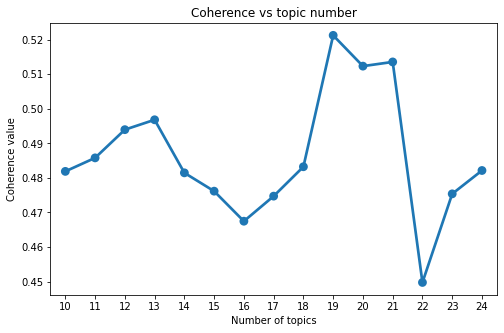

In [ ]:
# visualize coherence values vs number of topics
plt.figure(figsize=(8, 5))
sns.pointplot(x=list(range(10, 25, 1)), y=cherence_lda)
plt.xlabel("Number of topics")
plt.ylabel("Coherence value")
plt.title("Coherence vs topic number")
plt.show()

We can clearly see that the model with 19 topics has the highest Coherence score. Train the model with 19 topics.

# LDA model

In [ ]:
# LDA model with 19 topics
ldamodel = models.LdaModel(corpus, 
                           num_topics=19, 
                           id2word=dictionary, 
                           passes=50, 
                           eval_every=None, 
                           alpha='auto', 
                           eta='auto', 
                           chunksize=1000, 
                           iterations=200)

In [ ]:
# print topics
ldamodel.print_topics(num_words=15)

[(0,
  '0.045*"space" + 0.038*"nasa" + 0.035*"gov" + 0.013*"jpl_nasa" + 0.010*"local_bus" + 0.010*"space_shuttle" + 0.010*"launch" + 0.010*"moon" + 0.010*"prism_gatech" + 0.009*"henry" + 0.009*"jpl" + 0.009*"article" + 0.009*"shuttle" + 0.009*"orbit" + 0.008*"space_station"'),
 (1,
  '0.024*"andrew_cmu" + 0.019*"hockey" + 0.018*"uiuc" + 0.018*"andrew" + 0.016*"university_illinois" + 0.015*"article" + 0.014*"university" + 0.013*"cmu" + 0.011*"cso" + 0.010*"colorado" + 0.008*"frank" + 0.008*"illinois" + 0.008*"cso_uiuc" + 0.007*"carnegie_mellon" + 0.007*"sgi"'),
 (2,
  '0.014*"wire" + 0.013*"power" + 0.011*"purdue" + 0.011*"ecn_purdue" + 0.011*"ground" + 0.010*"circuit" + 0.010*"power_supply" + 0.009*"signal" + 0.009*"input" + 0.008*"mil" + 0.008*"university" + 0.008*"navy" + 0.008*"supply" + 0.008*"get_rid" + 0.008*"use"'),
 (3,
  '0.023*"armenian" + 0.014*"turkish" + 0.011*"war" + 0.010*"stanley_cup" + 0.010*"people" + 0.009*"greek" + 0.008*"turk" + 0.007*"freenet_carleton" + 0.007*"tu

# Assign topics to the original data

In [ ]:
# create DF with topics and probability scores for each text
topic_details = pd.DataFrame()
for i, row in enumerate(ldamodel[corpus]):
  row = sorted(row, key=lambda x: (x[1]), reverse=True)
  for j, (topic_num, prop_topic) in enumerate(row):
    if j==0:
      topic_details = topic_details.append(
          pd.Series([topic_num, prop_topic]), ignore_index=True
      )
topic_details.columns=["Topics", "% Score"]

In [ ]:
# assign tokens and original texts to the topics
topic_details.loc[:, 'Tokens'] = np.array(lemmatized, dtype='object')
topic_details.loc[:, 'Original text'] = newsgroups_train

In [ ]:
topic_details.loc[40:45]

,Topics,% Score,Tokens,Original text
40,9.0,0.356886,"[sean, garrison, subject, bonilla, nntp, posti...",From: (Sean Garrison)\nSubject: Re: Bonilla\n...
41,7.0,0.510100,"[root, ncube, com, operator, subject, fax, mod...",From: root@ncube.com (Operator)\nSubject: Re: ...
42,14.0,0.367355,"[cleveland, freenet, edu, sam, latonia, subjec...",From: ab245@cleveland.Freenet.Edu (Sam Latonia...
43,9.0,0.290688,"[paul, csd, csd, uwm, edu, paul, krueger, subj...",From: paul@csd4.csd.uwm.edu (Paul R Krueger)\n...
44,9.0,0.313854,"[cmeyer, bloch, stanford, edu, craig, meyer, s...",From: cmeyer@bloch.Stanford.EDU (Craig Meyer)\...
45,1.0,0.425725,"[robert, everett, brunskill, andrew, cmu, edu,...",From: Robert Everett Brunskill <rb6t+@andrew.c...
